In [1]:
# Curve fitting for downstream task scores

In [2]:
## Download W&B logs

In [5]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from olmo.scaling.scaling_laws.utils import downstream_bpb
from argparse import Namespace
import os

/Users/akshitab/virtuals/olmo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
WANDB_RESULTS = "wandb/amberish-rulebased"
FIGURES = "figures"

In [30]:
def get_name_size_length(run_name: str):
    run_name = run_name.split("/")[-1]
    size, length = run_name.split("-")[-2:]
    return run_name, size, length

In [52]:
import itertools
run_names = [
    f"ai2-llm/olmo-ladder/amberish-rulebased-{size}-{length}" 
    for size, length in itertools.product(["150M", "300M", "530M", "750M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}

for run_name in run_names:

    output_name = run_name.split("/")[-1]
    name, size, length = get_name_size_length(run_name)
    output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="throughput/total_tokens",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

In [38]:
## Setup

In [39]:
import numpy as np
import pandas as pd
import ladder
from olmo.scaling.scaling_laws.utils import validation as validation_names
from olmo.scaling.scaling_laws.utils import downstream_bpb as downstream_bpb_names
from olmo.scaling.scaling_laws.utils import downstream as downstream_names

In [40]:
from typing import Optional

def get_gflops(run_name: str, length_in_tokens: Optional[int] = None):
    run_name, size, length = get_name_size_length(run_name)
    length_in_tokens = length_in_tokens or ladder.parse_length(length, ladder.parse_size(size))
    flops = ladder.MODEL_GFLOPS[size]
    return flops * length_in_tokens / 1e9

def get_params(run_name: str):
    run_name, size, length = get_name_size_length(run_name)
    params = ladder.MODEL_PARAMS[size]
    return params

In [41]:
# We only include ce loss and the 6 dolma sets, as these are the sets we can include in the paper
ce_columns = [
    'eval/c4_en-validation/CrossEntropyLoss',
    'eval/dolma_books-validation/CrossEntropyLoss',
    'eval/dolma_common-crawl-validation/CrossEntropyLoss',
    'eval/dolma_pes2o-validation/CrossEntropyLoss',
    'eval/dolma_reddit-validation/CrossEntropyLoss',
    'eval/dolma_stack-validation/CrossEntropyLoss',
    'eval/dolma_wiki-validation/CrossEntropyLoss',
]

In [410]:
import numpy as np
import matplotlib.pyplot as plt
from olmo.scaling.scaling_laws.utils import (
    get_coefficients_huber,
    chinchilla_flops_fit,
    grad_chinchilla_flops_fit,
    chinchilla_n_d_fit,
    grad_chinchilla_n_d_fit,
    FinalConfig,
    get_final_data_by_name,
    get_data_by_name,
)

configs = {
    "150m": {
        "paths": [
            "wandb/amberish-rulebased/150M-1xC.csv",
            "wandb/amberish-rulebased/150M-2xC.csv",
            "wandb/amberish-rulebased/150M-5xC.csv",
            "wandb/amberish-rulebased/150M-10xC.csv"
        ],
        "mode": "train",
        "n": 151898880,
        "label": "150m",
        "color": "darkred"
    },
    "300m": {
        "paths": [
            "wandb/amberish-rulebased/300M-1xC.csv",
            "wandb/amberish-rulebased/300M-2xC.csv",
            "wandb/amberish-rulebased/300M-5xC.csv",
            "wandb/amberish-rulebased/300M-10xC.csv"
        ],
        "mode": "train",
        "n": 319980544,
        "label": "300m",
        "color": "darkorange"
    },
    "530m": {
        "paths": [
            "wandb/amberish-rulebased/530M-1xC.csv",
            "wandb/amberish-rulebased/530M-2xC.csv",
            "wandb/amberish-rulebased/530M-5xC.csv",
            "wandb/amberish-rulebased/530M-10xC.csv"
        ],
        "mode": "train",
        "n": 530074944,
        "label": "530m",
        "color": "gold"
    },
    "700m": {
        "paths": [
            "wandb/amberish-rulebased/750M-1xC.csv",
            "wandb/amberish-rulebased/750M-2xC.csv",
            "wandb/amberish-rulebased/750M-5xC.csv",
            "wandb/amberish-rulebased/750M-10xC.csv"
        ],
        "mode": "train",
        "n": 681297408,
        "label": "750m",
        "color": "darkgreen"
    },
    "1b": {
        "paths": [
            "wandb/amberish-rulebased/1B-1xC.csv",
            "wandb/amberish-rulebased/1B-2xC.csv",
            "wandb/amberish-rulebased/1B-5xC.csv",
            #"wandb/amberish-rulebased/1B-10xC.csv"
        ],
        "mode": "train",
        "n": 1176832000,
        "label": "1b",
        "color": "teal"
    },
    "1b-final": {
        "paths": [
            "wandb/amberish-rulebased/1B-10xC.csv"
        ],
        "mode": "eval",
        "n": 1176832000,
        "label": "1b",
        "color": "teal"
    }
}

In [411]:
configs = {name: FinalConfig(**config) for name, config in configs.items()}

In [412]:
from collections import defaultdict
import csv

def get_all_data_by_name(configs, keys):
    data_by_name = defaultdict(lambda: defaultdict(lambda: []))
    for name, config in configs.items():
        for path in config.paths:
            with open(path) as file_ref:
                reader = csv.DictReader(file_ref)
                rows = [row for row in reader]
                # rows = rows[-num_to_avg:]
                values = []
                for row in rows:
                    y = np.mean([float(row[key]) for key in keys])
                    data_by_name[name][path].append(y)
    return data_by_name

In [414]:
from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k, b):
    o = L / (1 + np.exp(- k * (x - x0))) + b
    return (o)

def reverse_sigmoid(y, L, x0, k, b):
    return x0 - 1/k * np.log((L / (y - b)) -1)

# Error with using huber fit; possibly due to incorrect bounds (try later).

# def sigmoid_fit(x, p):
#     return p[0] / (1 + np.exp(-p[2] * (x - p[1]))) + p[3]

# def grad_sigmoid_fit(x, p):
#     grad_L = 1 / (1 + np.exp(-p[2] * (x - p[1])))
#     grad_x0 = p[0] * p[2] * sigmoid_fit(x, p) * (1 - sigmoid_fit(x, p))
#     grad_k = p[0] * (x - p[1]) * sigmoid_fit(x, p) * (1 - sigmoid_fit(x, p))
#     grad_b = 1
#     return [grad_L, grad_x0, grad_k, grad_b]

# # fit the parameters
# coefficients = get_coefficients_huber(
#     train_nds,
#     train_ys,
#     sigmoid_fit,
#     grad_sigmoid_fit,
#     p0=[-1.3, 0.5, 3, 0.3],
#     bounds=None, #[(None, 0), (None, None), (None, None), (None, None)],
# )

In [413]:
def get_train_x_y(x_dict, y_dict):
    train_xs, train_ys = [], []
    for name, path_dict in x_dict.items():
        for path in path_dict:
            x_data = x_dict[name][path]
            y_data = y_dict[name][path]
            config = configs[name]
            if config.mode == "train":
                train_xs += x_data
                train_ys += y_data
    return train_xs, train_ys

def apply_func(the_dict, func):
    for name, path_dict in the_dict.items():
        for path in path_dict:
            ndata = [func(d) for d in the_dict[name][path]]
            the_dict[name][path] = ndata
    return the_dict

In [500]:
def size_length_from_path(path):
    #wandb/amberish-rulebased/150M-1xC.csv
    name = path.split("/")[-1].strip(".csv")
    return name.split("-")

def get_dataframe(x_dict, y_dict):
    df = pd.DataFrame()
    xs = []
    ys = []
    sizes = []
    lengths = []
    modes = []
    runs = []
    for name, path_dict in x_dict.items():
        config = configs[name]
        for path in path_dict:
            size, length = size_length_from_path(path)
            run_name = f"{size}-{length}"
            x_data = x_dict[name][path]
            y_data = y_dict[name][path]
            size = [size for _ in range(len(x_data))]
            length = [length for _ in range(len(x_data))]
            mode = [config.mode for _ in range(len(x_data))]
            run = [run_name for _ in range(len(x_data))]
            xs += x_data
            ys += y_data
            sizes += size
            lengths += length
            modes += mode
            runs += run
    df["xs"] = xs
    df["ys"] = ys
    df["sizes"] = sizes
    df["lengths"] = lengths
    df["modes"] = modes
    df["runs"] = runs
    return df

In [501]:
def get_predictions(x_dict, y_dict, coefficients, apply_x=lambda x: x):

    predicted_data_by_name = defaultdict(lambda: defaultdict(lambda: {"xs": [], "ys": []}))
    plotted_predicted_data_by_name = defaultdict(lambda: defaultdict(lambda: {"xs": [], "ys": []}))

    all_x_data = []
    
    for name, path_dict in x_dict.items():
        for path in path_dict:
            x_data = x_dict[name][path]
            y_data = y_dict[name][path]
            predicted_data_by_name[name][path] = {
                "xs": apply_x(x_data),
                "ys": [sigmoid(x_val, *coefficients) for x_val in x_data],
            }
            all_x_data += x_data

    
    # xs = np.linspace(min(all_x_data), max(all_x_data), 100)
    xs = np.linspace(max(all_x_data), reverse_sigmoid(0.93, *coefficients), 100)
    plotted_predicted_data_by_name = {
        "xs": xs,
        "ys": [sigmoid(x_val, *coefficients) for x_val in xs],
    }
    return predicted_data_by_name, plotted_predicted_data_by_name

In [625]:
def name_from_path(path):
    return path.split("/")[-1].strip(".csv")

def length_from_path(path):
    #wandb/amberish-rulebased/150M-1xC.csv
    name = path.split("/")[-1].strip(".csv")
    return name.split("-")[1]

def plot_fig(x_dict, y_dict, predicted_data_by_name, plotted_predicted_data_by_name, coefficients):

    L, x0, k, b = coefficients

    for name, path_dict in x_dict.items():
        config = configs[name]
        handle = plt.gca()
        for path in path_dict:
            x_data = x_dict[name][path]
            y_data = y_dict[name][path]
            plt.scatter(x_data, y_data, color="white", edgecolors=config.color, s=7.0)
        
            predicted_data = predicted_data_by_name[name][path]

            if config.mode == "eval" and length_from_path(path) == "10xC":
                #for x, y, y_pred in zip(x_data, y_data, predicted_data["ys"]):
                x = x_data[-1]
                y = y_data[-1]
                y_pred = predicted_data["ys"][-1]
                rel_error = (y_pred - y) / y
                plt.annotate(
                    f"{name_from_path(path)}: {rel_error * 100:+.1f}%",
                    (x, y),
                    textcoords="offset points",
                    xytext=(30, 5),
                    ha="center",
                    fontsize=8,
                    color="brown",
                )
                plt.scatter(x, y, marker="x", color="blue", label=f"actual = {y:0.4f}", s=50)
                plt.scatter(x, y, marker="^", color="black", label=f"predicted = {y_pred:0.4}", s=50)

    plt.plot(
        plotted_predicted_data_by_name["xs"],
        plotted_predicted_data_by_name["ys"],
        # plot_xs,
        # plot_ys,
        color="black",
        linestyle="--",
        linewidth=0.8,
    )

    # plt.text(
    #     x=0.25,
    #     y=0.50,
    #     s=f"σ(L, x0, k, b) \n = {L:.2f} / (1 + e^(-({k:.2f}(x - {x0:.2f})))) + {b:.2f}",
    #     fontsize=10,
    #     transform=plt.gca().transAxes,
    # )

    plt.legend(loc="upper right", ncols=2)
    
    plt.xlabel("bpb loss")
    plt.ylabel("task score")
    plt.title("Fitting final score")


def fit_and_plot(df, x_label, y_label):
    df = df.dropna()
    plt.scatter(df["xs"], df["ys"], color="white", edgecolors=df["sizes"].apply(lambda x: color_map[x]), s=7.0)

    train_xs = df[df["modes"]=="train"]["xs"]
    train_ys = df[df["modes"]=="train"]["ys"]

    train_xs = pd.concat([pd.Series([0.01]), train_xs], ignore_index=True)
    train_ys = pd.concat([pd.Series([1.0]), train_ys], ignore_index=True)

    coefficients, pcov = curve_fit(sigmoid, train_xs, train_ys, p0=[-1, 0.4, 3, 0.3], maxfev=1000000)
    df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))
    
    eval_row = df[df["modes"]=="eval"].iloc[-1]
    x = eval_row["xs"]
    y = eval_row["ys"]
    y_pred = eval_row["predicted_ys"]
    rel_error = (y_pred - y) / y
    
    plt.scatter(x, y, marker="x", color="blue", label=f"actual = {y:0.4f}", s=50)
    plt.scatter(x, y, marker="^", color="black", label=f"predicted = {y_pred:0.4}", s=50)
    plt.annotate(
        f"{name_from_path(path)}: {rel_error * 100:+.1f}%",
        (x, y),
        textcoords="offset points",
        xytext=(30, 5),
        ha="center",
        fontsize=8,
        color="brown",
    )
    
    #plotted_xs = np.linspace(df["xs"].max(), reverse_sigmoid(0.93, *coefficients), 100)
    plotted_xs = np.linspace(df["xs"].max(), 0.01, 100)
    plotted_ys = [sigmoid(x_val, *coefficients) for x_val in plotted_xs]
    
    plt.plot(
        plotted_xs,
        plotted_ys,
        color="black",
        linestyle="--",
        linewidth=0.8,
    )
    
    # plt.text(
    #     x=0.25,
    #     y=0.50,
    #     s=f"σ(L, x0, k, b) \n = {L:.2f} / (1 + e^(-({k:.2f}(x - {x0:.2f})))) + {b:.2f}",
    #     fontsize=10,
    #     transform=plt.gca().transAxes,
    # )
    
    plt.legend(loc="upper right", ncols=2)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title("Fitting final score")

In [626]:
### Hellaswag

In [627]:
# bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/hellaswag_rc_0shot_bpb_bpb"])
# downstream_loss = get_all_data_by_name(configs, ["eval/downstream/hellaswag_rc_0shot_len_norm"])
# train_xs, train_ys = get_train_x_y(bpb_loss, downstream_loss)

# coefficients, pcov = curve_fit(sigmoid, train_xs, train_ys, p0=[1, 0.4, 3, 0.3], maxfev=1000000)
# predicted_data_by_name, plotted_predicted_data_by_name = get_predictions(bpb_loss, downstream_loss, coefficients)

# plot_fig(bpb_loss, downstream_loss, predicted_data_by_name, plotted_predicted_data_by_name, coefficients)

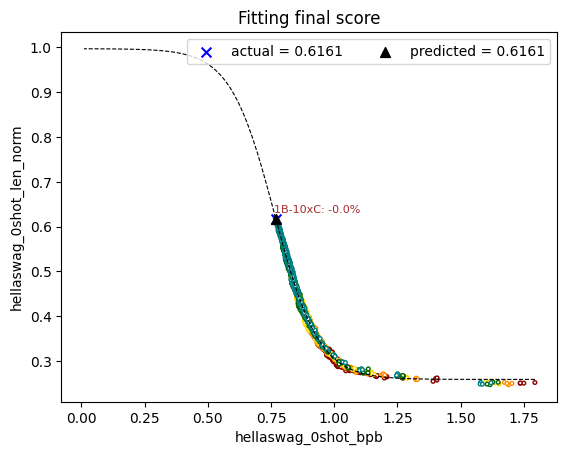

In [648]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/hellaswag_rc_0shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/hellaswag_rc_0shot_len_norm"])

df = get_dataframe(bpb_loss, downstream_loss)

fit_and_plot(df, "hellaswag_0shot_bpb", "hellaswag_0shot_len_norm")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


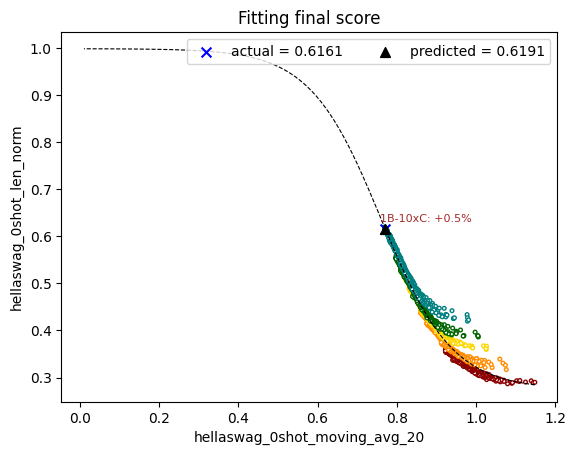

In [649]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/hellaswag_rc_0shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/hellaswag_rc_0shot_len_norm"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "hellaswag_0shot_moving_avg_20", "hellaswag_0shot_len_norm")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


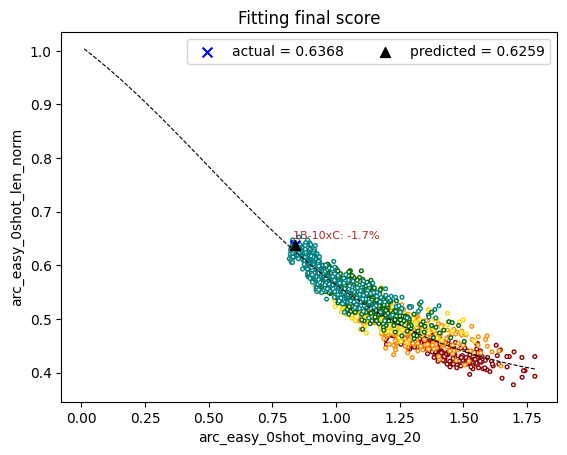

In [650]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/arc_easy_rc_0shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/arc_easy_rc_0shot_acc"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "arc_easy_0shot_moving_avg_20", "arc_easy_0shot_len_norm")

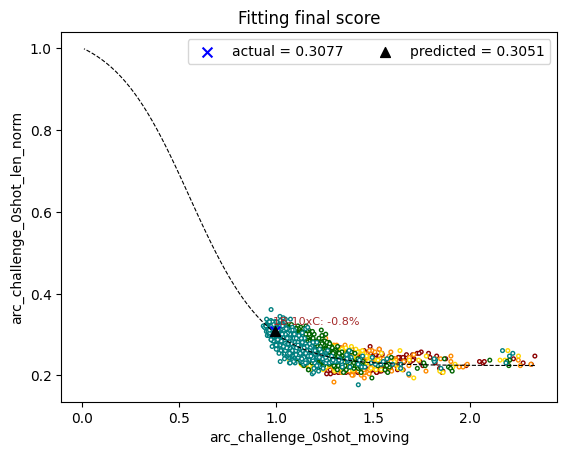

In [651]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/arc_challenge_rc_0shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/arc_challenge_rc_0shot_len_norm"])

df = get_dataframe(bpb_loss, downstream_loss)
#df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=1).mean())

fit_and_plot(df, "arc_challenge_0shot_moving", "arc_challenge_0shot_len_norm")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


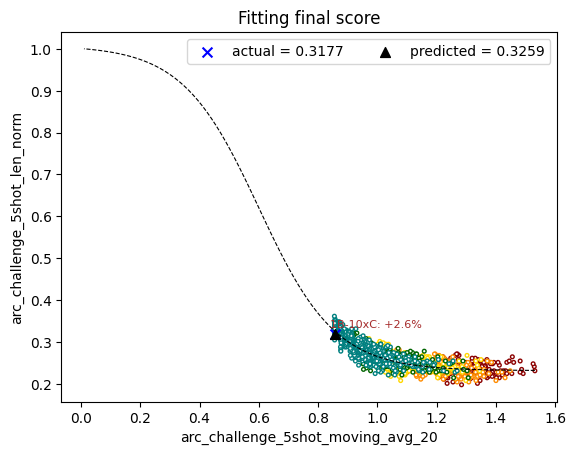

In [652]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/arc_challenge_rc_5shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/arc_challenge_rc_5shot_len_norm"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "arc_challenge_5shot_moving_avg_20", "arc_challenge_5shot_len_norm")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


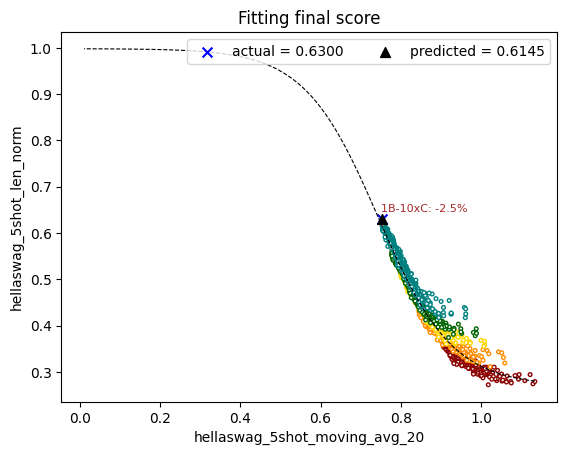

In [659]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/hellaswag_rc_5shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/hellaswag_rc_5shot_len_norm"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "hellaswag_5shot_moving_avg_20", "hellaswag_5shot_len_norm")

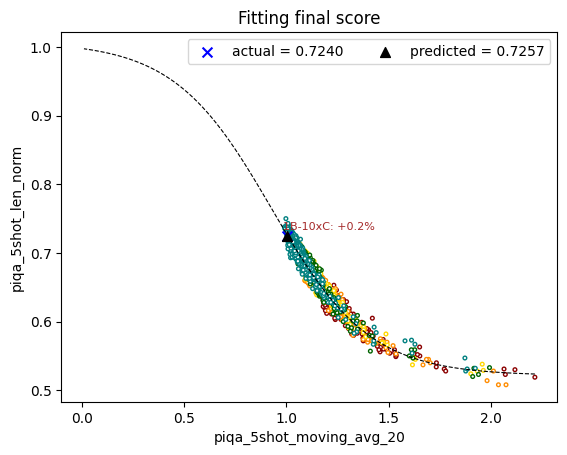

In [663]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/piqa_rc_5shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/piqa_rc_5shot_len_norm"])

df = get_dataframe(bpb_loss, downstream_loss)
#df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "piqa_5shot_moving_avg_20", "piqa_5shot_len_norm")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


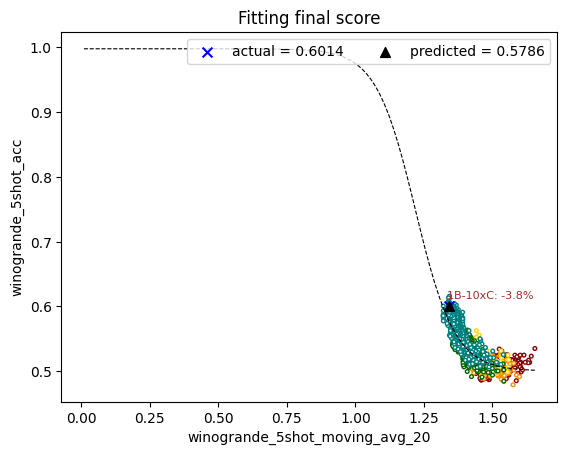

In [727]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/winogrande_rc_5shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/winogrande_rc_5shot_acc"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "winogrande_5shot_moving_avg_20", "winogrande_5shot_acc")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


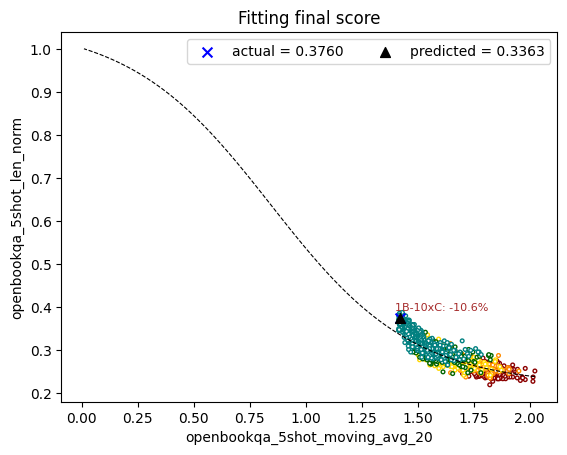

In [723]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/openbookqa_rc_5shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/openbookqa_rc_5shot_len_norm"])
ce_loss = get_all_data_by_name(configs, ce_columns)

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "openbookqa_5shot_moving_avg_20", "openbookqa_5shot_len_norm")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


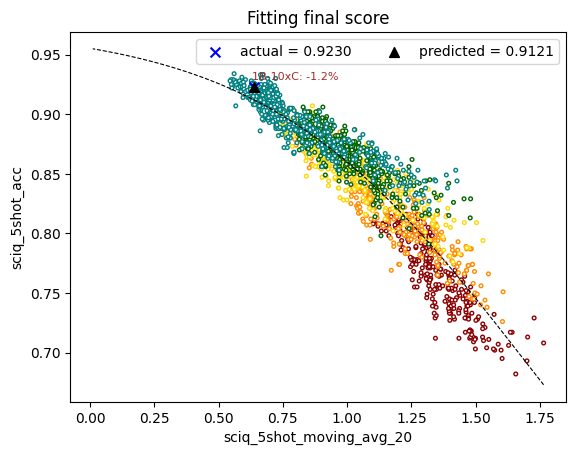

In [684]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/sciq_rc_0shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/sciq_rc_0shot_acc"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "sciq_5shot_moving_avg_20", "sciq_5shot_acc")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


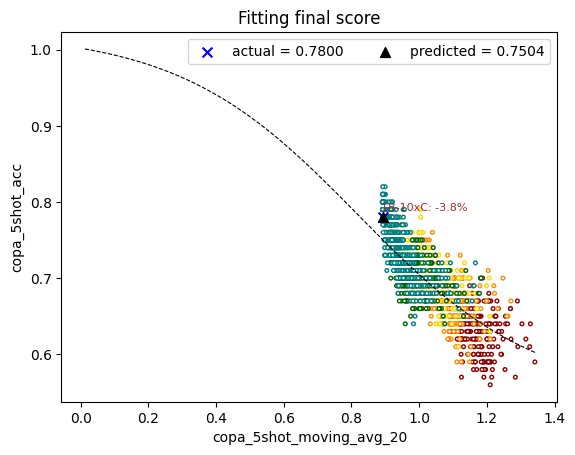

In [717]:
ce_loss = get_all_data_by_name(configs, ce_columns)
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/copa_rc_0shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/copa_rc_0shot_acc"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "copa_5shot_moving_avg_20", "copa_5shot_acc")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


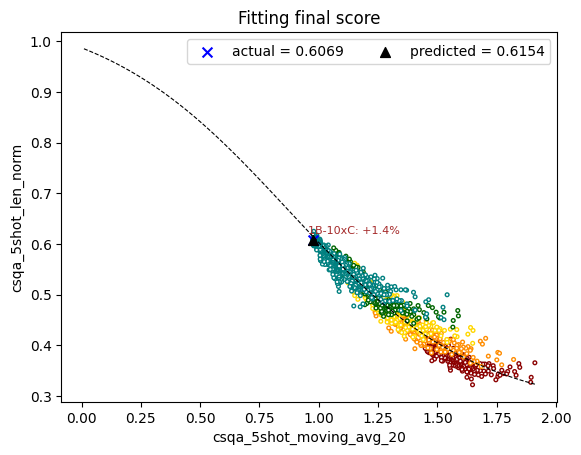

In [693]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/csqa_rc_5shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/csqa_rc_5shot_len_norm"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "csqa_5shot_moving_avg_20", "csqa_5shot_len_norm")

/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_53506/1268651060.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_ys"] = df["xs"].apply(lambda x: sigmoid(x, *coefficients))


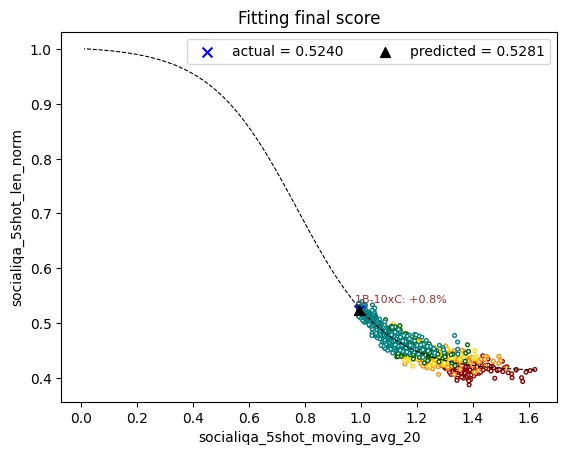

In [696]:
bpb_loss = get_all_data_by_name(configs, ["eval/downstream_bpb/socialiqa_rc_5shot_bpb_bpb"])
downstream_loss = get_all_data_by_name(configs, ["eval/downstream/socialiqa_rc_5shot_len_norm"])

df = get_dataframe(bpb_loss, downstream_loss)
df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "socialiqa_5shot_moving_avg_20", "socialiqa_5shot_len_norm")

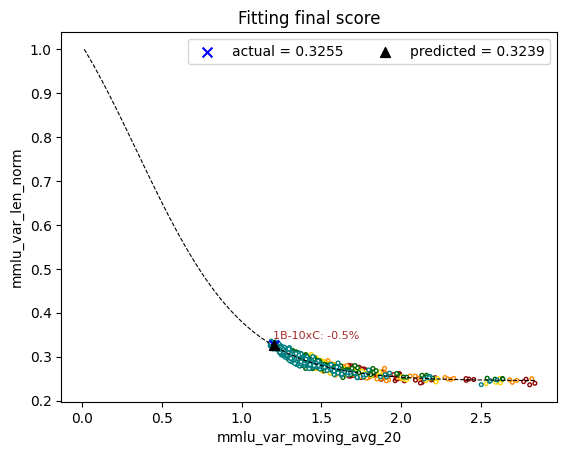

In [712]:
mmlu_names = ["mmlu_stem", "mmlu_humanities", "mmlu_social_sciences", "mmlu_other"]

bpb_loss = get_all_data_by_name(configs, [f"eval/downstream_bpb/{n}_var_bpb_bpb" for n in mmlu_names])
downstream_loss = get_all_data_by_name(configs, [f"eval/downstream/{n}_var_len_norm" for n in mmlu_names])

df = get_dataframe(bpb_loss, downstream_loss)
#df["xs"] = df.groupby('runs')['xs'].transform(lambda x: x.rolling(window=20).mean())

fit_and_plot(df, "mmlu_var_moving_avg_20", "mmlu_var_len_norm")